In [1]:

import os
from collections import Counter
import numpy as np


In [2]:
#lets do some preprocessing! 

with open('nepali.txt','r',encoding="utf8") as file:
    texts = file.read()
    sentences = texts.split('।')
    sentences = ' '.join(sentences)
    # we separated by sentences, now we separate by words! 
    eachWords = sentences.split(' ')

In [3]:
wordsToGiveADamn = Counter(eachWords).most_common(1000)
wordsToCheck = [w[0] for w in wordsToGiveADamn if not w[0] == '']

In [4]:
wordToIndex = {}
IndexToWord = {}
for index,word in enumerate(wordsToCheck):
    wordToIndex[word] = index
    IndexToWord[index] = word


In [5]:
wordsWeAreProcessing =[]
for eachWord in eachWords:
    if wordToIndex.get(eachWord):
        wordsWeAreProcessing.append(eachWord)
    

In [6]:
# just the 8000 words! 
wordsWeAreProcessing = wordsWeAreProcessing[:500]

In [7]:
#changing our set of words to vector
wordsToVector = []
for eachWord in wordsWeAreProcessing:
    index= wordToIndex.get(eachWord)
    zeroIndex =np.zeros(len(wordToIndex))
    zeroIndex[index] = 1
    wordsToVector.append(zeroIndex)

In [8]:
class HiddenLayer():
    def __init__(self,layer_number,activation_function='sigmoid'):
        self.layer_number=layer_number
        self.activation_function=activation_function

class NeuralNetwork():
    
    def __init__(self,input_number,output_number):
        self.raw_activations=[]
        self.activations=[]
        self.layers=[]
        
        self.input_number=input_number
        self.output_number=output_number

    def sigmoid(self,z,derivative=False):
        if derivative:
            return self.sigmoid(z)*(1-self.sigmoid(z))
        return 1.0/(1.0+np.exp(-z))
        
    def add(self,layer):
        self.layers.append(layer)
        
    def glorot_initializer(self,x,y):
        r = np.sqrt((6/(x+y)))
        value = np.random.uniform(-r,r,(x,y))
        return value
    
    def weight_initializer(self,x,y):
        return np.random.rand(x,y)
        
    def initialize(self):
        layerNumbers=[]
        layerNumbers.append(self.input_number)
        
        for eachLayer in self.layers:
            layerNumbers.append(eachLayer.layer_number)
        
        layerNumbers.append(self.output_number)
        
        #so layerNumbers contains the input,hiddenLayers and output in a list! 
        # we initialize with glorot initialization! 
        
        self.weights= [self.weight_initializer(x,y) for x,y in zip(layerNumbers[1:],layerNumbers[:-1])]
        self.biases=[np.random.rand(x,1) for x in layerNumbers[1:]]
        
        
    def feed_forward(self,a):
        for w,b in zip(self.weights,self.biases):
            a= np.dot(w,a)+b
            z=self.sigmoid(a)
        return z
    
    #works only for emvedding
    def get_middle_layer(self,a):
        for w,b in zip(self.weights,self.biases):
            a= np.dot(w,a)+b
            return a
            
    def backpropagate(self,x,y):
        #we are at the last layer! 
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        
        # okay feed_forwarding here!! 
        self.activations = []
        self.raw_activations = []
        
        a=x
        for w,b in zip(self.weights,self.biases):
            a= np.dot(w,a)+b
            self.raw_activations.append(a)
            z=self.sigmoid(a)
            self.activations.append(z)
        
        delta_val = self.activations[-1]-y
                
        delta = delta_val*self.sigmoid(self.raw_activations[-1],derivative=True)
        #the first gradient from base and weight in final layer!!!
        #delta should have same shape as that of activation!.. 
        # we would have same no of activations as weights! 
        nabla_b[-1] = delta
        
        nabla_w[-1] = np.dot(delta,self.activations[-2].T)
        
        # now we calculate nabla_b and nabla_w for other layers! 
        for j in range(len(self.weights)-2,0,-1):
            sigmoid_value = self.sigmoid(self.raw_activations[j],derivative=True)
            if j==1:
                delta = np.dot(self.weights[j+1].T,delta)*sigmoid_value
            else:
                delta = np.dot(self.weights[j+1].T,delta)
            nabla_b[j] = delta
            nabla_w[j] = np.dot(delta,self.activations[j-1].T)
        
#         # activations doesnt contain input, so we do for this loop too! 
        sigmoid_value = self.sigmoid(self.raw_activations[0],derivative=True)
        delta = np.dot(self.weights[1].T,delta)*sigmoid_value
        
        nabla_b[0] = delta
        nabla_w[0] = np.dot(delta,x.T)
        
        return nabla_b,nabla_w
        
        
        # why are we using Transpose here? Because delta is of shape 4*1 suppose and self.activations would also be 4.1
        # so we use 4*1,1*4 to get 4*4 gradient! 
        #HURRAY THIS WORKS FOR BACKPROPAGATION FOR FINAL LAYER.. HOW ABOUT MOVING FROM IT NOW? 
#       return weight_gradient,bias_gradient
    
    def calculate_loss(self,calc_y,actual_y):
        epsilon = 0.0000001
        return -1*np.sum(actual_y*np.log(calc_y+epsilon) + (1-actual_y)*np.log(1-calc_y+epsilon))
#         return 0.5*np.sum(np.square(calc_y-actual_y))

    def test(self,x_actual,y_actual):
        x = np.expand_dims(x_actual,axis=1)
        y = np.expand_dims(y_actual,axis=1)
        calculated_value = self.feed_forward(x)
        print('Got this {}'.format(self.raw_activations[0]),end='\n')
        print('Loss => {}'.format(self.calculate_loss(calculated_value,y)))

    def gradientDescent(self,batch_x,batch_y,epochs=100,learning_rate=0.1,verbose=False):
        prev = 0.1*epochs
        for i in range(epochs):
            for x,y in zip(batch_x,batch_y):
                
                x=np.expand_dims(x,axis=1)
                y=np.expand_dims(y,axis=1)
                bias_gradient,weight_gradient = self.backpropagate(x,y)
                self.biases  = [b-learning_rate*db for b,db in zip(self.biases,bias_gradient)]
                self.weights = [w-learning_rate*dw for w,dw in zip(self.weights,weight_gradient)]
                #testing the random data from the batch! 
            if verbose:
                if i==int(prev):
                    prev = prev + 0.1*epochs 
                    randomIndex= np.random.randint(0,len(batch_x)-1)
                    self.test(batch_x[randomIndex],batch_y[randomIndex])

In [9]:
wordsToVector=np.array(wordsToVector)
X = wordsToVector[:len(wordsToVector)-1]
Y = wordsToVector[1:len(wordsToVector)]

In [10]:
SIZEOFINPUT = len(wordsToVector[0])
SIZEOFOUTPUT = SIZEOFINPUT


In [11]:
nn = NeuralNetwork(SIZEOFINPUT,SIZEOFOUTPUT)

hiddenLayer1= HiddenLayer(20,'sigmoid')

nn.add(hiddenLayer1)

nn.initialize()


In [12]:
nn.gradientDescent(X,Y,100,verbose=True)

Got this [[-2.23669892]
 [-1.81662753]
 [-1.95328643]
 [-1.60976535]
 [-2.47841306]
 [ 2.35297227]
 [-1.87308565]
 [-2.45991199]
 [ 0.31080869]
 [-2.30422137]
 [-1.29575209]
 [ 1.58047893]
 [-1.04003999]
 [ 3.20166917]
 [ 2.42568128]
 [-0.73484694]
 [-2.33054594]
 [-0.1899229 ]
 [-1.47505882]
 [-0.11004645]]
Loss => 8.769943817104043
Got this [[-2.34822504]
 [-1.9221679 ]
 [-2.05207486]
 [-1.71851162]
 [-2.58417323]
 [ 2.46885174]
 [-1.98789092]
 [-2.5651895 ]
 [ 0.35509792]
 [-2.41121548]
 [-1.40025936]
 [ 1.69869754]
 [-1.13603708]
 [ 3.29738674]
 [ 2.54211726]
 [-0.82728301]
 [-2.43580027]
 [-0.25650163]
 [-1.58655545]
 [-0.1527111 ]]
Loss => 7.641724449041483
Got this [[-2.39531357]
 [-1.96642361]
 [-2.09374537]
 [-1.76779632]
 [-2.63247481]
 [ 2.52293329]
 [-2.03414689]
 [-2.6111073 ]
 [ 0.36781783]
 [-2.45644373]
 [-1.44786977]
 [ 1.75864858]
 [-1.18035763]
 [ 3.33448311]
 [ 2.59392922]
 [-0.87230848]
 [-2.48257396]
 [-0.29050324]
 [-1.63882197]
 [-0.17671303]]
Loss => 6.85382022

In [13]:
# word embedding time! 
#how about saving words and their corresponding latent vectors? 
wordEmbeddingRelation = {}
k=0
for word in wordsToCheck:
    index= wordToIndex.get(word)
    zeroIndex =np.zeros(len(wordToIndex))
    zeroIndex[index] = 1
    zeroIndex= np.expand_dims(zeroIndex,axis=1)
    value = nn.get_middle_layer(zeroIndex)
    wordEmbeddingRelation[word] = value

In [24]:
#let me get the matrices of all the words!!! 

values = np.array(list(wordEmbeddingRelation.values()))
values = values.reshape(values.shape[0],values.shape[1])

In [72]:
#creating PCA by myself! 
# you think I cannot do that? 
def get2DimVector(vectors):
    values = np.array(list(wordEmbeddingRelation.values()))
    words = list(wordEmbeddingRelation.keys())
    
    values = values.reshape((values.shape[0],values.shape[1]))
    
    eachColumnValues = np.array([vectors[:,i] for i in range(20)])
    
    values = []
    
    for eachColumnValue in eachColumnValues:
        mean = np.mean(eachColumnValue)
        std_dev= np.std(eachColumnValue)
        values.append((eachColumnValue-mean)/std_dev)
    
    values = np.array(values)
    
    cov_mat = np.cov(values)
    
    eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
    
    eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
    
    eigen_pairs.sort(key=lambda k: k[0], reverse=True)
    
    w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
    X_train = values.T.dot(w)
    
    return X_train

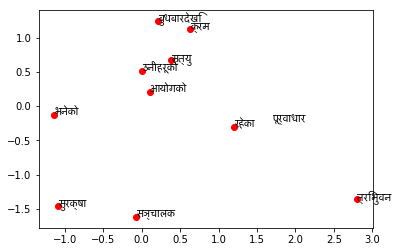

In [80]:
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rcParams

fpath = os.path.join(rcParams["datapath"], "fonts/ttf/MangalRegular.ttf")
prop = fm.FontProperties(fname=fpath)


X_train = get2DimVector(values)
corelatedWords = list(wordEmbeddingRelation.keys())

ValuesPrint = 10

fig, ax = plt.subplots()
ax.scatter(X_train[:ValuesPrint,0], X_train[:ValuesPrint,1],c='r')

for i,txt in enumerate(X):
    ax.annotate(u'{}'.format(corelatedWords[i]), (X_train[i,0], X_train[i,1]),fontproperties=prop)
    if i==ValuesPrint:
        break